## Introduction

I obtained data on Airbnbs in Edinburgh for both 2019/20 (compiled on 25th June 2019) and 2020/21 (compiled on 23rd June 2020). All of the data were collected by the [Inside Airbnb](http://insideairbnb.com/get-the-data.html) project, although only the most recent year is available on their website. The 2019-20 data were sourced on [Kaggle](https://www.kaggle.com/thoroc/edinburgh-inside-airbnb). First, I take a first at the listings from the **2020/21** data. This is a verbose description of my initial exploration of the **listings** dataset. The time series data is discussed elsewhere. By the end of this notebook, I will have a clean, complete, and properly encoded dataset ready for integration with the time series data, then modelling. 

This dataset contains 106 fields describing 12,658 Airbnb listings.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

listings = pd.read_csv('../data20/listings.csv')

listings.shape

(12658, 106)

## Missing Data

There are missing data in this dataset. 

In [64]:
listings.isna().any().any()

True

In [65]:
listings.loc[:, listings.isnull().any()].columns

Index(['summary', 'space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'xl_picture_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'revi

## Exploring Pricing

First I need to transform price columns into numeric values.

In [66]:
from pandas.api.types import is_numeric_dtype

def format_price(dataframe, column):
    if not is_numeric_dtype(dataframe[column]):
        dataframe[column] = dataframe[column].str.replace('$', '')
        dataframe[column] = dataframe[column].str.replace(',', '')
        dataframe[column] = pd.to_numeric(dataframe[column])

format_price(listings, "price")
format_price(listings, "extra_people")

Airbnbs can opt to charge extra for additional people staying in larger properties. The `price` column only refers to `guests_included`, and additional guests are charged at `extra_people`. Therefore, I can create another column which is price per included guest (`price_pig` = `price`/`guests_included`). I can also create a column that is price at full capacity (`price_fullcap` = `price` + `extra_people` * (`accomodates` - `guests_included`)). On 6 occassions this results in a negative number for `price_fullcap`, because the owner of the Airbnb has listed the price as including more individuals than the property can accomodate. In such cases, `price_fullcap` is just set to `price`.

In [67]:
listings = listings.assign(price_pig = lambda dataframe : dataframe['price']/dataframe['guests_included'])

listings = listings.assign(price_fullcap = lambda dataframe : dataframe['price'] + dataframe['extra_people'] * (dataframe['accommodates'] - dataframe['guests_included']))

listings.query('price_pig > price_fullcap')[['price_pig', 'price_fullcap', 'accommodates', 'price', 'extra_people', 'guests_included']]

listings['price_fullcap'] = np.where((listings.price_pig > listings.price_fullcap),listings.price,listings.price_fullcap)

### Distributions & Outlier Detection

The histogram of price shows an extreme right skew. Price here refers to the **mean** price per included guests per night over a 365 day period. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001965CEEE9C8>]],
      dtype=object)

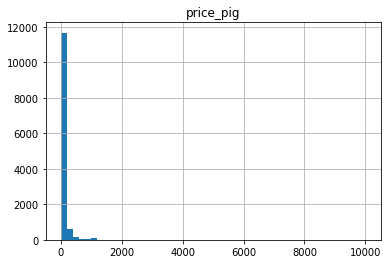

In [68]:
listings.hist(column = 'price_pig', bins = 50)

There are values of a dataset where the price per included guest is 0. The maximum price per included guest per night is £10,000. A really special feature of this dataset is that it includes the links to the Airbnb's pages. This means that, so long as the listing is still active, I can literally check to see if there is a reason that a value is extreme. I choose to use my own knowledge of hotel prices to create sensible upper and lower bounds for the data. Personally, I have found statistical methods (e.g. 3 standard deviations) often hide real features of the data. I use the price per included guest to make these judgements, because a property may appear to be an outlier just because it sleeps a large number of individuals. 

In [70]:
listings['price_pig'].min()

0.0

In [82]:
listings['price_pig'].max()

10000.0

Any Airbnb less than £8 per person a night would be a potential outlier, as this seems unreasonably cheap. There are 20 Airbnbs under £8 a night, and three of these are listed as costing nothing at all. I visually inspect these properties in the data for any feature that might explain this (e.g. they all have the same host, or are a special property type...). Airbnbs under £8 per person tend include many more people in the base rate than the mean for all Airbnbs in this dataset (mean ± standard deviation: 7.65 ± 4.75 ± vs. 1.77 ± 1.48). It makes sense that Airbnbs that include more people would be cheaper per person because the 'bare minimum' costs to the host are split between all of the people. 

In [84]:
listings[listings.price_pig < 8][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
578,7.000000,2,https://www.airbnb.com/rooms/3032366,14630118,6,74,2.0,Apartment,20.0
790,2.600000,3,https://www.airbnb.com/rooms/3769281,3713949,15,0,2.0,Apartment,0.0
925,6.250000,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
2597,2.916667,3,https://www.airbnb.com/rooms/12512258,67762663,12,162,1.0,House,0.0
3239,2.916667,1,https://www.airbnb.com/rooms/13937408,82866543,12,296,1.0,Apartment,10.0
4544,1.636364,1,https://www.airbnb.com/rooms/18609453,101731795,11,48,1.0,Townhouse,0.0
4566,6.666667,3,https://www.airbnb.com/rooms/18664020,128824975,6,120,3.0,Apartment,100.0
4919,5.000000,1,https://www.airbnb.com/rooms/19346425,130895130,6,187,3.0,Apartment,0.0
4953,5.000000,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
5366,4.062500,3,https://www.airbnb.com/rooms/19903475,140937670,16,141,1.0,Apartment,0.0


In fact, if I filter the results to only include Airbnbs with less than 5 guests (I choose this number because it is two deviations away from the mean for the whole sample), then I am only left with 5 results. Three of these are most likely errors as they are £0. I choose to exclude these 5 results.

In [86]:
listings[(listings.price_pig < 8) & (listings.guests_included < 5)][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
925,6.25,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
4953,5.00,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
5609,0.00,5,https://www.airbnb.com/rooms/20177668,106987467,1,0,1.0,Apartment,0.0
5870,0.00,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0
12331,0.00,1,https://www.airbnb.com/rooms/42279232,268308479,1,0,NaN,Boutique hotel,0.0


In [87]:
listings = listings[(listings.price > 8) | (listings.guests_included >= 5)]

A luxury apartment might charge £1000 a night per person if it was also centrally located. Moreover, recall that price here is derived from the mean price, so Airbnbs that are exclusively available on the night of some special event (e.g. the Edinburgh Hogmanay festival) may seem inflated compared to others. Note there is no way for me to check this because of the unreliability of the availability data (this will be discussed more in my EDA of the calendar dataset). Amazingly, there are 59 Airbnbs in this dataset that exceed £1000 per person per night. Here, I do observe some trends - there are some host ids that are enriched in these very expensive lets (e.g. 29783383, 50725883). After exploring some of the links, I could find no reason for these values (indeed, these values do not reflect what is currently on Airbnb for these properties, if their link was still valid). Due to this uncertainty, I choose to drop these data points.  

In [93]:
listings[listings.price_pig > 1000][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people', 'has_availability']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people,has_availability
183,3326.000000,1,https://www.airbnb.com/rooms/692353,3540219,6,344,3.0,Apartment,0.0,t
1617,8000.000000,9,https://www.airbnb.com/rooms/7361960,29783383,1,0,2.0,Apartment,0.0,t
1629,8000.000000,4,https://www.airbnb.com/rooms/7384650,29783383,1,0,1.0,House,0.0,t
2571,1500.000000,1,https://www.airbnb.com/rooms/12385633,21782787,1,0,1.0,Apartment,0.0,t
2974,3324.500000,1,https://www.airbnb.com/rooms/13487525,11362736,6,336,5.0,Apartment,0.0,t
3455,2415.000000,1,https://www.airbnb.com/rooms/14225887,86457709,1,0,1.0,Apartment,0.0,t
3699,1500.000000,2,https://www.airbnb.com/rooms/15081589,66064051,1,328,30.0,Townhouse,0.0,t
4137,1172.750000,2,https://www.airbnb.com/rooms/17167280,646220,4,57,1.0,Apartment,0.0,t
4732,1250.000000,3,https://www.airbnb.com/rooms/19036213,68538373,2,81,1.0,Apartment,15.0,t
5681,7000.000000,2,https://www.airbnb.com/rooms/20258438,144388294,1,0,3.0,Apartment,200.0,t


In [94]:
listings = listings[(listings.price < 1000)]

The skew in price per included guest is still very extreme. However, I am unwilling to blindly remove any more data points at this stage without further justification for their removal. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001965E5444C8>]],
      dtype=object)

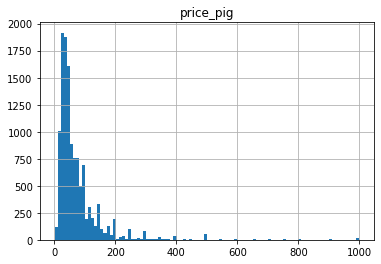

In [95]:
listings.hist(column = 'price_pig', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001965E749B88>]],
      dtype=object)

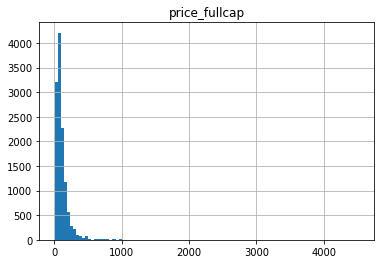

In [96]:
listings.hist(column = 'price_fullcap', bins = 100)

## Exploring Ameneties 

### One Hot Encoding

## Exploring Neighbourhoods

### One Hot Encoding

## Exploring Ratings and Host Characteristics

### Distributions and Outlier Detection

## Finalising the Dataset